# Prepare Environment

In [1]:
import os
from pprint import pprint
import io
from datetime import timedelta
from importlib import reload

import adalib

from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import pandas as pd
import math
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import (
    plot_cross_validation_metric,
    plot_forecast_component,
)

# Acquire

In [2]:
df = pd.read_csv('precipitation.csv')

# Summarize Data

In [3]:
adalib.summarize(df)

RANDOM SAMPLE OF 10
        Unnamed: 0      STATION        DATE  PRCP
89695        89695  US1TXBXR148  2009-10-01   0.0
35025        35025  US1TXKN0054  2017-04-20   0.0
88036        88036  US1TXWO0023  2009-10-24   0.0
124031      124031  USC00417628  1982-11-03   0.6
73149        73149  US1TXKN0065  2014-06-07   0.0
120259      120259  USC00410902  1989-12-04   0.0
165979      165979  USC00411777  1956-02-12   0.0
203878      203878  USC00416276  1927-12-17   0.0
9021          9021  US1TXBXR269  2018-04-10   0.0
12577        12577  US1TXCML061  2018-07-28   0.0

SHAPE: (232574, 4)

DESCRIPTION
          Unnamed: 0           PRCP
count  232574.000000  229661.000000
mean   116286.500000       0.099676
std     67138.475091       0.393292
min         0.000000       0.000000
25%     58143.250000       0.000000
50%    116286.500000       0.000000
75%    174429.750000       0.000000
max    232573.000000      11.500000

INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232574 ent

In [4]:
adalib.df_missing_vals_by_col(df)

,nmissing,percentage,nempty
Unnamed: 0,0,0.000000,0
STATION,0,0.000000,0
DATE,0,0.000000,0
PRCP,2913,1.252505,0


In [5]:
df.set_index('DATE')

station_counts = df.groupby('STATION').count()
station_counts = station_counts.sort_values(by=['PRCP'], ascending=True)
print(station_counts.head())
print(station_counts.tail(10))

             Unnamed: 0  DATE  PRCP
STATION                            
US1TXBXR362         101   101   101
US1TXGP0126         106   106   106
US1TXGP0103         107   107   107
US1TXBXR073         108   108   108
US1TXCML038         127   127   127
             Unnamed: 0   DATE   PRCP
STATION                              
US1TXBXR027        4402   4402   4394
US1TXBXR015        4407   4407   4407
US1TXAT0001        4487   4487   4487
US1TXCML008        4600   4600   4576
USW00012909        8346   8346   8337
USC00411777        8962   8962   8949
USC00415454       10562  10562  10551
USC00416276       29087  29087  28003
USC00417628       33026  33026  32855
USC00410902       44512  44512  44475


USC00410902 is the longest running station for collecting precipitation data. I will use this station alone for my initial model.

In [6]:
df_initial = df[(df['STATION'] == 'USC00410902')]

In [7]:
df_initial.STATION.value_counts()

USC00410902    44512
Name: STATION, dtype: int64

In [8]:
print(df_initial.DATE.max())
print(df_initial.DATE.min())

2019-05-16
1893-01-17


In [9]:
df_initial.dtypes

Unnamed: 0      int64
STATION        object
DATE           object
PRCP          float64
dtype: object

In [10]:
df_initial['DATE'] = pd.to_datetime(df_initial['DATE'])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_initial.dtypes

Unnamed: 0             int64
STATION               object
DATE          datetime64[ns]
PRCP                 float64
dtype: object

Dropping Nans from the dataframe to feed into initial model. 

In [12]:
df_initial.dropna(inplace=True)
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44475 entries, 14189 to 232573
Data columns (total 4 columns):
Unnamed: 0    44475 non-null int64
STATION       44475 non-null object
DATE          44475 non-null datetime64[ns]
PRCP          44475 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
df_initial = df_initial.drop(['Unnamed: 0'], axis=1)
df_initial

,STATION,DATE,PRCP
14189,USC00410902,2017-05-01,0.00
14190,USC00410902,2017-05-02,0.00
14191,USC00410902,2017-05-03,0.00
14192,USC00410902,2017-05-04,0.00
14193,USC00410902,2017-05-05,0.00
14194,USC00410902,2017-05-06,0.00
14195,USC00410902,2017-05-07,0.00
14196,USC00410902,2017-05-08,0.00
14197,USC00410902,2017-05-09,0.00
14198,USC00410902,2017-05-10,0.08


In [14]:
df_initial = df_initial.set_index(pd.DatetimeIndex(df_initial['DATE']))

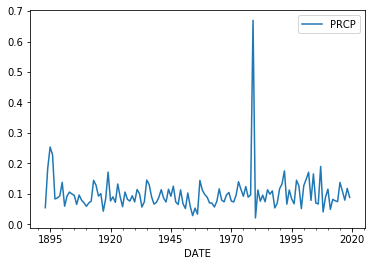

In [15]:
df_initial.resample('Y').mean().plot()

## Train/Test Split

In [16]:
df_inital = df_initial.sort_values(by='DATE')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'DATE' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [17]:
#taking the yearly averages for train and test sets

aggregation = "mean"

train = df_initial[:'2005-01'].resample("Y").agg(aggregation)
test = df_initial['2005-02': '2019'].resample("Y").agg(aggregation)

In [18]:
print("Observations: %d" % (len(train.values) + len(test.values)))
print("Training Observations: %d" % (len(train)))
print("Testing Observations: %d" % (len(test)))

Observations: 128
Training Observations: 113
Testing Observations: 15


In [19]:
train.head()

,PRCP
DATE,
1893-12-31,0.054185
1894-12-31,0.183563
1895-12-31,0.253571
1896-12-31,0.228194
1897-12-31,0.082947


In [20]:
test.min()

PRCP    0.040273
dtype: float64

In [21]:
train = train[train.PRCP < 0.6]

## Modeling

In [22]:
def plot_data_and_predictions(train, test, predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(train, test, predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        plt.title(f"{train.name}")

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(f"{train.name}\n{label}")

    plt.legend(loc='best')
    plt.show()

In [23]:
pd.concat([train.head(3), train.tail(3)])

,PRCP
DATE,
1893-12-31,0.054185
1894-12-31,0.183563
1895-12-31,0.253571
2003-12-31,0.078219
2004-12-31,0.165301
2005-12-31,0.089677


In [24]:
pd.concat([test.head(3), test.tail(3)])

,PRCP
DATE,
2005-12-31,0.067605
2006-12-31,0.066411
2007-12-31,0.189889
2017-12-31,0.079014
2018-12-31,0.117781
2019-12-31,0.088222


In [25]:
train.isna().sum()

PRCP    0
dtype: int64

In [26]:
train.dropna(inplace=True)

## Simple Moving Average

In [27]:
def ts_simple_average(train, test):
    yhat = pd.DataFrame(dict(actual=test))
    yhat["avg_forecast"] = train.mean()
    plot_and_eval(train, test, yhat.avg_forecast, yhat.actual)
    return yhat

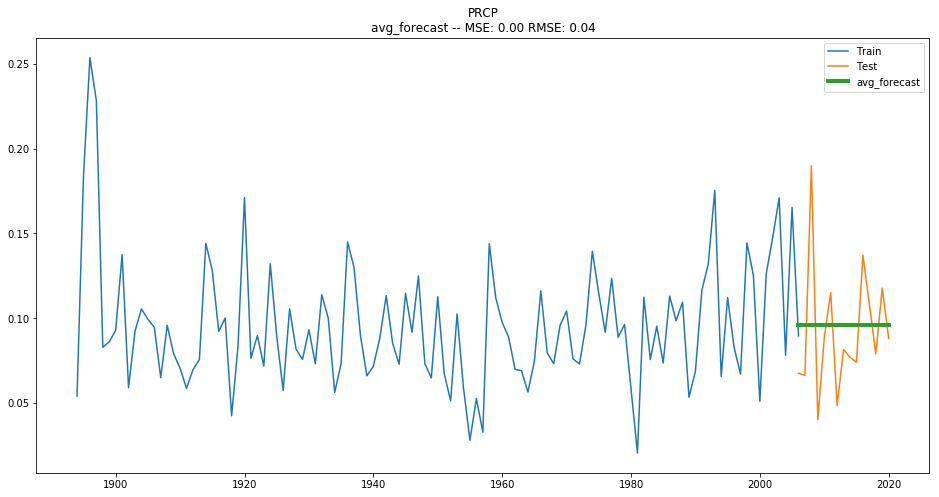

,actual,avg_forecast
DATE,,
2005-12-31,0.067605,0.095832
2006-12-31,0.066411,0.095832
2007-12-31,0.189889,0.095832
2008-12-31,0.040273,0.095832
2009-12-31,0.088378,0.095832
2010-12-31,0.115233,0.095832
2011-12-31,0.048658,0.095832
2012-12-31,0.081589,0.095832
2013-12-31,0.077019,0.095832


In [28]:
ts_simple_average(train['PRCP'], test['PRCP'])

## Moving Average

In [29]:
def ts_moving_average(train, test, periods):
    yhat = pd.DataFrame(dict(actual=test))
    for p in periods:
        yhat[f"moving_avg_forecast_{p}"] = (
            train.rolling(p).mean().iloc[-1]
        )

    forecasts = [yhat[f"moving_avg_forecast_{p}"] for p in periods]

    plot_and_eval(train, test, forecasts, test, linewidth=2)

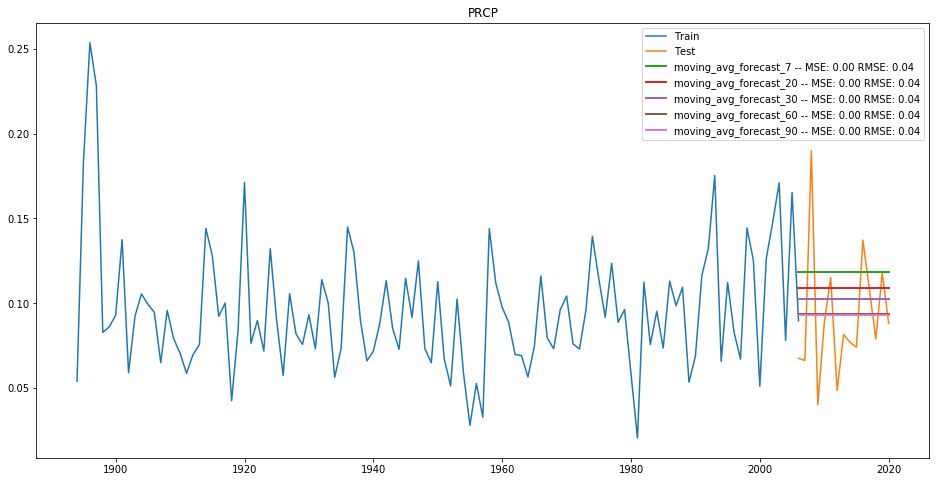

In [30]:
period_vals = [7, 20, 30, 60, 90]
ts_moving_average(train['PRCP'], test['PRCP'], period_vals)

## Prophet

In [31]:
dfp= df_initial

In [32]:
dfp.rename(columns={'DATE':'ds', 'PRCP': 'y'}, inplace=True)

In [33]:
dfp = dfp.reset_index()
dfp.drop(columns=['STATION', 'DATE'], inplace=True)

In [34]:
dfp.head()

,ds,y
0,2017-05-01,0.0
1,2017-05-02,0.0
2,2017-05-03,0.0
3,2017-05-04,0.0
4,2017-05-05,0.0


In [35]:
m = Prophet()
m.fit(dfp)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


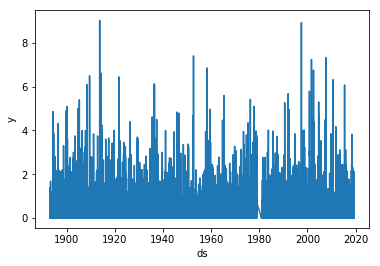

In [36]:
sns.lineplot(dfp.ds, dfp.y)
plt.show()

In [37]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
44835,2020-05-11
44836,2020-05-12
44837,2020-05-13
44838,2020-05-14
44839,2020-05-15


In [38]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
44835,2020-05-11,0.152067,-0.330618,0.654826
44836,2020-05-12,0.144107,-0.335105,0.612231
44837,2020-05-13,0.150755,-0.316450,0.603458
44838,2020-05-14,0.154963,-0.322307,0.628442
44839,2020-05-15,0.155817,-0.291526,0.663654


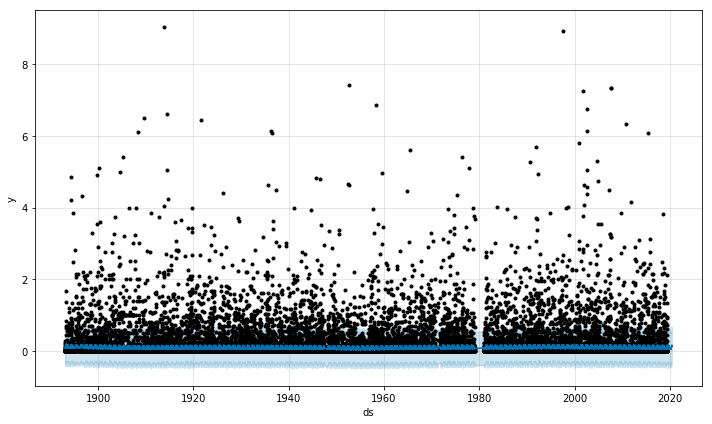

In [39]:
fig1 = m.plot(forecast)

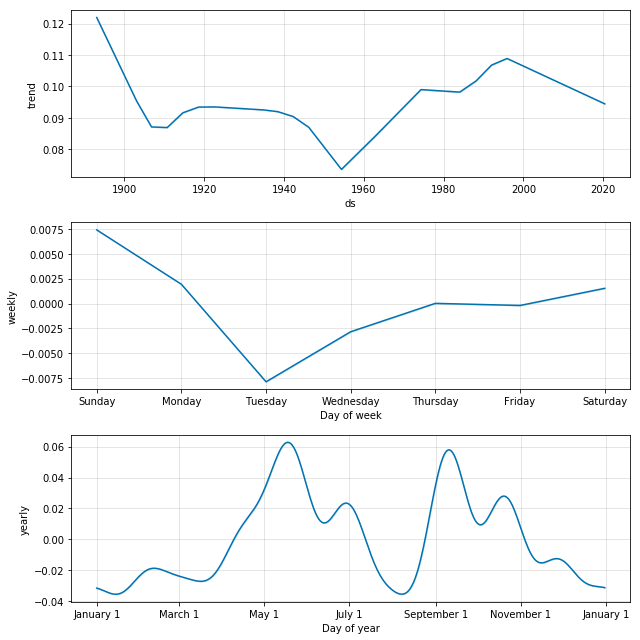

In [40]:
fig2 = m.plot_components(forecast)

## ARIMA

In [41]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

In [42]:
train = train.reset_index()

In [43]:
arima_df = train.set_index(train['DATE'])

In [44]:
type(arima_df)

pandas.core.frame.DataFrame

In [45]:
#fit model
data = pd.Series(arima_df.PRCP, index=arima_df.DATE)
model = ARIMA(data, order=(0,1,0))
model_fit = model.fit(disp=0)

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/signal/signa

In [46]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.PRCP   No. Observations:                  111
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 185.212
Method:                           css   S.D. of innovations              0.046
Date:                Mon, 03 Jun 2019   AIC                           -366.424
Time:                        16:56:02   BIC                           -361.005
Sample:                             1   HQIC                          -364.225
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.074      0.941      -0.008       0.009


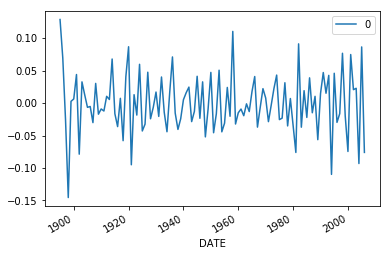

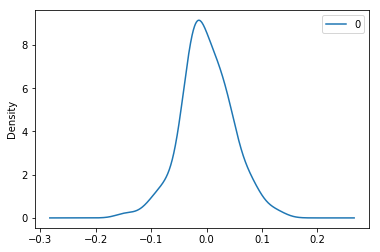

                  0
count  1.110000e+02
mean   5.195202e-10
std    4.582209e-02
min   -1.455675e-01
25%   -2.551509e-02
50%   -6.400518e-03
75%    2.765706e-02
max    1.290582e-01


In [47]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## ARIMA 2

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
test = test.reset_index()

In [50]:
train = train.set_index(['DATE'])
test = test.set_index(['DATE'])

In [51]:
test.dtypes

PRCP    float64
dtype: object

In [52]:
# history = [x for x in train]
# predictions = list()
# for t in test:
#     model = ARIMA(history, order=(1,0,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.3f' % error)
# # plot
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()


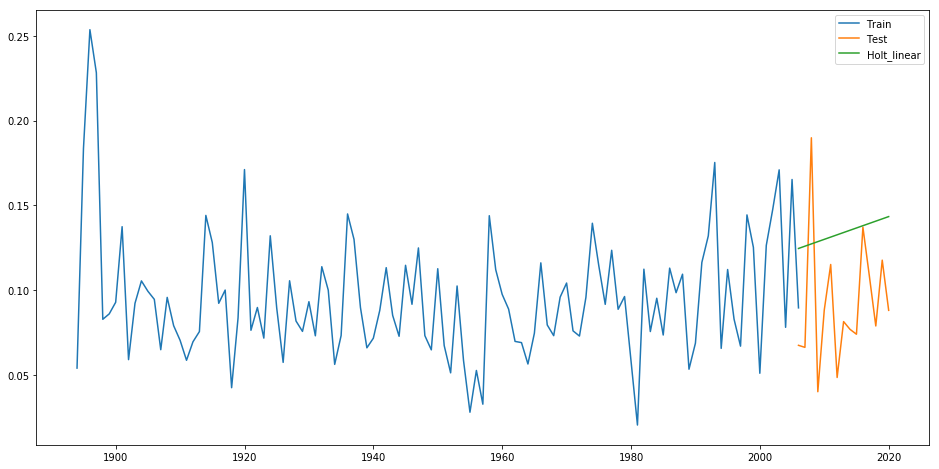

In [53]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['PRCP'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['PRCP'], label='Train')
plt.plot(test['PRCP'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()